In [1]:
!pip install mediapipe opencv-python

  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-health-checking 1.67.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.5 which is incompatible.
grpcio-status 1.67.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.5 which is incompatible.
grpcio-tools 1.67.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.5 which is incompatible.
label-studio 1.13.1 requires jsonschema==3.2.0, but you have jsonschema 4.23.0 which is incompatible.
opentelemetry-proto 1.28.2 requires protobuf<6.0,>=5.0, but you have protobuf 4.25.5 which is incompatible.


## Project: Fall Detection

### Solution 1: Calculate angles Using Mediapipe 

In [44]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return angle if angle <= 180 else 360.0 - angle

def draw_landmarks(image, landmarks):
    mp_drawing.draw_landmarks(
        image, 
        landmarks, 
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
    )

def process_landmarks(landmarks):
    return {
        "nose": [landmarks[mp_pose.PoseLandmark.NOSE.value].x, landmarks[mp_pose.PoseLandmark.NOSE.value].y],
        "left_shoulder": [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y],
        "right_shoulder": [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y],
        "left_hip": [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y],
        "right_hip": [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    }

def determine_fall_status(landmarks):
    lm = process_landmarks(landmarks)

    torso_height = (lm["nose"][1] + lm["left_shoulder"][1] + lm["right_shoulder"][1]) / 3
    hip_height = (lm["left_hip"][1] + lm["right_hip"][1]) / 2

    torso_angle = calculate_angle(lm["left_shoulder"], lm["right_shoulder"], [(lm["left_hip"][0] + lm["right_hip"][0]) / 2, hip_height])

    if torso_height > hip_height + 0.15 and torso_angle > 60:
        return "FALLEN"
    elif torso_height > hip_height + 0.05 and torso_angle > 45:
        return "FALLING"
    else:
        return "STABLE"

def process_frame(pose, frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.pose_landmarks:
        draw_landmarks(image, results.pose_landmarks)
        landmarks = results.pose_landmarks.landmark

        fall_status = determine_fall_status(landmarks)
        color = (0, 255, 0) if fall_status == "STABLE" else (0, 0, 255) if fall_status == "FALLEN" else (0, 255, 255)
        cv2.putText(image, fall_status, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2, cv2.LINE_AA)

    return image

video_path = [
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/50 Ways to Fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/funny fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/f_c.mp4"
]
video = cv2.VideoCapture(video_path[0])

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break

        processed_frame = process_frame(pose, frame)
        cv2.imshow('Fall Detection', processed_frame)

        if cv2.waitKey(10) & 0xFF == 27:
            break

video.release()
cv2.destroyAllWindows()


### Solution 2: Calcualte Width and Height Using Mediapipe
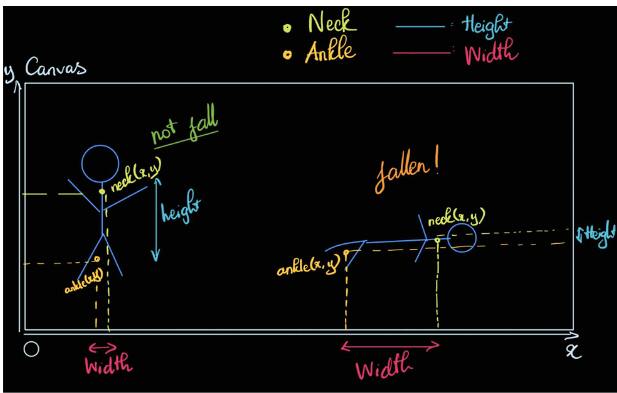

In [4]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Initialize variables for fall detection
previous_neck_y = None
fall_detected = False

def calculate_height_width(neck, ankle):
    """Calculate the perceived height and width of the person."""
    height = abs(neck[1] - ankle[1])  # Vertical distance between neck and ankle
    width = abs(neck[0] - ankle[0])   # Horizontal width (approximate)

    return height, width

def is_falling(current_neck_y, height, width, ankle_position):
    """Determine if the person is falling based on vertical and horizontal movements."""
    global previous_neck_y, previous_ankle_x, fall_detected

    # Calculate vertical neck movement
    if previous_neck_y is not None:
        vertical_displacement = abs(current_neck_y - previous_neck_y)

        height_threshold = height * 0.3 if height < 0.3 else height * 0.5

        # Fall detection conditions
        if vertical_displacement > height_threshold:  # Vertical displacement threshold
            # Check if the width of the person is greater than the height
            if width > height:
                fall_detected = True
            else:
                fall_detected = False

    previous_neck_y = current_neck_y
    return fall_detected

def process_frame(pose, frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.pose_landmarks:
        # Draw pose landmarks
        mp_drawing.draw_landmarks(
            image, 
            results.pose_landmarks, 
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

        # Extract neck and ankle landmarks
        landmarks = results.pose_landmarks.landmark
        try:
            neck = [
                landmarks[mp_pose.PoseLandmark.NOSE.value].x,
                landmarks[mp_pose.PoseLandmark.NOSE.value].y
            ]
            left_ankle = [
                landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y
            ]
            right_ankle = [
                landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y
            ]
            # Average of left and right ankle for a better approximation
            ankle = [(left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2]

            # Calculate height and width of the bounding box
            height, width = calculate_height_width(neck, ankle)

            cv2.putText(image, f"Height = {height}", (15, 150), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 2, cv2.LINE_AA)
            cv2.putText(image, f"Width = {width}", (20, 200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 2, cv2.LINE_AA)
            # Detect fall based on neck and ankle positions
            if is_falling(neck[1], height, width, ankle):
                cv2.putText(image, "Fall Detected!", (10, 100), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                cv2.putText(image, "Stable", (10, 100), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
        
        except IndexError:
            # Handle missing landmarks (neck or ankle not detected)
            cv2.putText(image, "Detecting...", (10, 100), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 2, cv2.LINE_AA)
            
    return image

# Load video or webcam feed
video_path_2 = "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/50 Ways to Fall.mp4"
cap = cv2.VideoCapture(video_path_2)  # Replace 'your_video.mp4' with the video path

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process each frame for fall detection
        image = process_frame(pose, frame)
        
        # Display the fall detection results
        cv2.imshow('Fall Detection', image)
        
        # Exit on pressing 'q'
        if cv2.waitKey(10) == 27:
            break

cap.release()
cv2.destroyAllWindows()

### Pose Estimation  + Optical Flow

In [11]:
import cv2
import mediapipe as mp
import numpy as np
import time 

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

previous_points = None
previous_frame = None
fall_detected = False
fall_time_threshold = 3
last_fall_time = None

def calculate_height_width(neck, ankle):
    height = abs(neck[1] - ankle[1])  # Vertical distance between neck and ankle
    width = abs(neck[0] - ankle[0])   # Horizontal width (approximate)

    return height, width

def is_falling_with_optical_flow(displacements, width, height):
    global fall_detected
    magnitudes = np.linalg.norm(displacements, axis=1)
    
    if width < height:
        fall_detected = False

    motion_threshold = 40
    if np.any(magnitudes > motion_threshold):
        if width > height:
            fall_detected = True
        else:
            fall_detected = False

def draw_optical_flow(image, previous_points, next_points, status, threshold=1.0):
    """Draw more motion vectors to visualize optical flow."""
    for i, (prev, next_point) in enumerate(zip(previous_points, next_points)):
        if status[i]:  # Only draw if the point is successfully tracked
            x1, y1 = prev.ravel()
            x2, y2 = next_point.ravel()

            # Calculate the magnitude of displacement
            displacement = np.linalg.norm(next_point - prev)

            # Only draw arrows if the displacement is larger than a threshold
            if displacement > threshold:
                cv2.arrowedLine(
                    image,
                    (int(x1), int(y1)), (int(x2), int(y2)),
                    color=(0, 255, 0), 
                    thickness=2,
                    tipLength=0.3  
                )

def check_fall_duration():
    global last_fall_time
    if fall_detected:
        if last_fall_time is None:
            last_fall_time = time.time()  # Start the timer
        else:
            if time.time() - last_fall_time > fall_time_threshold:
                return True  
    else:
        last_fall_time = None  # Reset if no fall detected

    return False

def process_frame(pose, frame):
    global previous_points, previous_frame, dramatically_change, fall_detected

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.pose_landmarks:
        # Draw pose landmarks
        mp_drawing.draw_landmarks(
            image, 
            results.pose_landmarks, 
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

        # Extract neck and ankle landmarks
        landmarks = results.pose_landmarks.landmark
        try:
            neck = [
                landmarks[mp_pose.PoseLandmark.NOSE.value].x * frame.shape[1],
                landmarks[mp_pose.PoseLandmark.NOSE.value].y * frame.shape[0]
            ]
            left_ankle = [
                landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x * frame.shape[1],
                landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y * frame.shape[0]
            ]
            right_ankle = [
                landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x * frame.shape[1],
                landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y * frame.shape[0]
            ]
            # Average of left and right ankle for better approximation
            ankle = [(left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2]

            # Calculate height and width of the bounding box
            height, width = calculate_height_width(neck, ankle)

            # Optical Flow calculations
            current_points = np.array([neck, ankle], dtype=np.float32)
            if previous_frame is not None and previous_points is not None:
                # Calculate optical flow
                next_points, status, error = cv2.calcOpticalFlowPyrLK(
                    previous_frame, cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
                    previous_points, None  # Pass None for initial guesses
                )

                if next_points is not None and status.sum() > 0:
                    displacements = next_points - previous_points

                    # Use the calculated flow to check for sudden motion
                    is_falling_with_optical_flow(displacements, width, height)

                    # Draw optical flow vectors
                    draw_optical_flow(image, previous_points, next_points, status)

                # Update previous points
                previous_points = next_points
                previous_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


            # Update previous frame and points
            previous_points = current_points
            previous_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            if check_fall_duration():
                fall_detected = True

            # Display results
            if fall_detected:
                cv2.putText(image, "Fall Detected!", (10, 100), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                cv2.putText(image, "Stable", (10, 100), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
                
        except IndexError:
            # Handle missing landmarks (neck or ankle not detected)
            cv2.putText(image, "Detecting...", (10, 100), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 2, cv2.LINE_AA)

    return image

video_path = [
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/50 Ways to Fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/funny fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/f_c.mp4"
]
cap = cv2.VideoCapture(video_path[2])

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        start_time = time.time()
        
        if not ret:
            break

        # Process each frame for fall detection
        image = process_frame(pose, frame)

        end_time = time.time()
        fps = 1 / (end_time - start_time)  # Frames per second
        cv2.putText(image, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 255), 2, cv2.LINE_AA)
        
        # Display the fall detection results
        cv2.imshow('Fall Detection', image)
        
        # Exit on pressing 'q'
        if cv2.waitKey(10) == 27:
            break

cap.release()
cv2.destroyAllWindows()

### Solution 3: Using YOLO

In [57]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import time

# Constants
CONFIDENCE_THRESHOLD = 0.5

# Load YOLO model
model_path = os.path.join('..', 'runs', 'detect', 'train11', 'weights', 'best.pt')
model = YOLO(model_path)

video_path = [
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/50 Ways to Fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/funny fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/f_c.mp4"
]
video = cv2.VideoCapture(video_path[2])

if not video.isOpened():
    print("Error: Could not open video file.")
else:
    while True:
        control, frame = video.read()
        if not control:
            print("End of video reached or error reading frame.")
            break

        # Start timing for FPS calculation
        start_time = time.time()

        # Run YOLO model inference
        results = model(frame)
        im_array = frame.copy()

        # Process results
        for r in results:
            for box in r.boxes:
                class_id = int(box.cls.item())  # Class ID
                confidence = box.conf.item()  # Confidence score

                if confidence >= CONFIDENCE_THRESHOLD:
                    bbox = box.xyxy[0].cpu().numpy().astype(int)
                    class_name = model.names[class_id]

                    # Assign color based on class name
                    if class_name == "fallen":
                        color = (0, 20, 255)
                    elif class_name == "stand":
                        color = (255, 0, 0)
                    else:
                        color = (255, 127, 127)

                    # Draw bounding box and label
                    label = f"{class_name}: {confidence:.2f}"
                    cv2.rectangle(im_array, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
                    cv2.putText(im_array, label, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, color, 2)

        end_time = time.time()
        fps = 1 / (end_time - start_time)
        cv2.putText(im_array, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 255), 2, cv2.LINE_AA)

        # Show results
        cv2.imshow('Detections with FPS', im_array)

        # Exit on pressing 'Esc' key
        if cv2.waitKey(10) == 27:
            break

# Release video and destroy windows
video.release()
cv2.destroyAllWindows()



0: 384x640 (no detections), 52.6ms
Speed: 1.5ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 fallen, 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 30.9ms
Speed: 1.0ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.1ms
Speed: 2.0ms preprocess, 23.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 stand, 24.0ms
Speed: 1.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.7ms
Speed: 2.1ms preprocess, 23.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.8ms
Speed: 2.0ms preprocess, 23.8ms inference, 0.0ms

### Solution 4: Use YOLO's bounding boxes to calculate width and height, then use w>h to decide

In [50]:
import cv2
import numpy as np
from ultralytics import YOLO

# Load YOLO model
model = YOLO('yolo11l.pt')

# Threshold for determining if a person has fallen
FALL_THRESHOLD = 1.2  # Adjust this value as needed

def calculate_height_width(bbox):
    """Calculate the height and width of the bounding box."""
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    return height, width

def is_falling(width, height):
    """Determine if a person has fallen based on bounding box dimensions."""
    return width > height * FALL_THRESHOLD

# Load video or webcam feed
# video_path = 'C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/funny fall.mp4'
video_path = [
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/50 Ways to Fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/funny fall.mp4",
    "C:/Users/MINH KHAI/ML/Python+Js Web App/FullStackWebApp/PlantDiseaseDetection/backend/videos/f_c.mp4"
]
video = cv2.VideoCapture(video_path[2])

if not video.isOpened():
    print("Error: Could not open video file.")
else:
    while True:
        control, frame = video.read()
        if not control:
            print("End of video reached or error reading frame.")
            break
            
        start_time = time.time()

        # Perform detection using YOLO
        results = model(frame)
        im_array = frame.copy()

        # Draw YOLO detections on the frame
        for r in results:
            for bbox in r.boxes:
                # Check if the detected object is a person
                if int(bbox.cls[0]) == 0:  # Assuming class 0 is "person"
                    bbox_coords = bbox.xyxy[0].cpu().numpy()  # Convert to (x1, y1, x2, y2)
                    bbox_height, bbox_width = calculate_height_width(bbox_coords)

                    # Determine the label based on fall detection
                    if is_falling(bbox_width, bbox_height):
                        label_text = "Fallen"
                        color = (0, 0, 255)  # Red for fallen
                    else:
                        label_text = "Stable"
                        color = (0, 255, 0)  # Green for stable

                    # Draw bounding box and the new label
                    x1, y1, x2, y2 = map(int, bbox_coords)
                    cv2.rectangle(im_array, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(im_array, label_text, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        end_time = time.time()
        fps = 1 / (end_time - start_time)
        cv2.putText(im_array, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Detections', im_array)

        # Use a small delay; press 'Esc' to exit
        if cv2.waitKey(10) == 27:  # Exit on 'Esc' key
            break

video.release()
cv2.destroyAllWindows()


0: 384x640 1 person, 1 bench, 1 tennis racket, 23.4ms
Speed: 1.0ms preprocess, 23.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 1 sports ball, 33.7ms
Speed: 5.5ms preprocess, 33.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 1 sports ball, 25.3ms
Speed: 2.0ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 1 sports ball, 1 baseball glove, 26.0ms
Speed: 1.4ms preprocess, 26.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 1 baseball glove, 23.8ms
Speed: 3.0ms preprocess, 23.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 1 baseball glove, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bench, 1 baseball glove, 25.3ms
Speed: 1.0ms prepr